In [1]:
import pandas as pd


df = pd.read_csv("C:/Users/mmrha/Desktop/cmu/Independent study/python/bankingmin.csv")
print(df.head())

   age  job  marital  education  default  housing  loan  contact  month  \
0   41    2        1          1        3        2     1        1      3   
1   49    3        2          7        3        2     1        1      3   
2   49   10        2          3        1        1     1        1      3   
3   41   10        2          6        3        2     1        1      3   
4   45    2        2          3        3        2     1        1      3   

   day_of_week  campaign  previous  poutcome  emp.var.rate  cons.price.idx  \
0            1         1         0         2           1.1          93.994   
1            1         1         0         2           1.1          93.994   
2            1         1         0         2           1.1          93.994   
3            1         1         0         2           1.1          93.994   
4            1         1         0         2           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  
0          -36.4      4.857       519

In [2]:

from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K


latent_dimension = 1
batch_size = 20
hidden_nodes = 16


input_encoder = Input(shape=(18,), name="Input_Encoder")
batch_normalize1 = BatchNormalization()(input_encoder)
hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)
z = Dense(latent_dimension, name="Mean")(batch_normalize2)

In [3]:
from keras import Model


encoder = Model(input_encoder, z)

In [4]:
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)
decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)
decoded = Dense(18, activation="linear", name="Decoded")(batch_normalize2)

In [5]:
decoder = Model(input_decoder, decoded, name="Decoder")

In [6]:
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Encoder (InputLayer)   [(None, 18)]              0         
_________________________________________________________________
model (Functional)           (None, 1)                 457       
_________________________________________________________________
Decoder (Functional)         (None, 18)                406       
Total params: 863
Trainable params: 761
Non-trainable params: 102
_________________________________________________________________


In [7]:
from tensorflow.random import set_seed


set_seed(2021)
ae.compile(loss="mean_squared_error", optimizer="adam")
history = ae.fit(
    df, df, shuffle=True, epochs=3000, batch_size=20, validation_split=0.2, verbose=0
).history

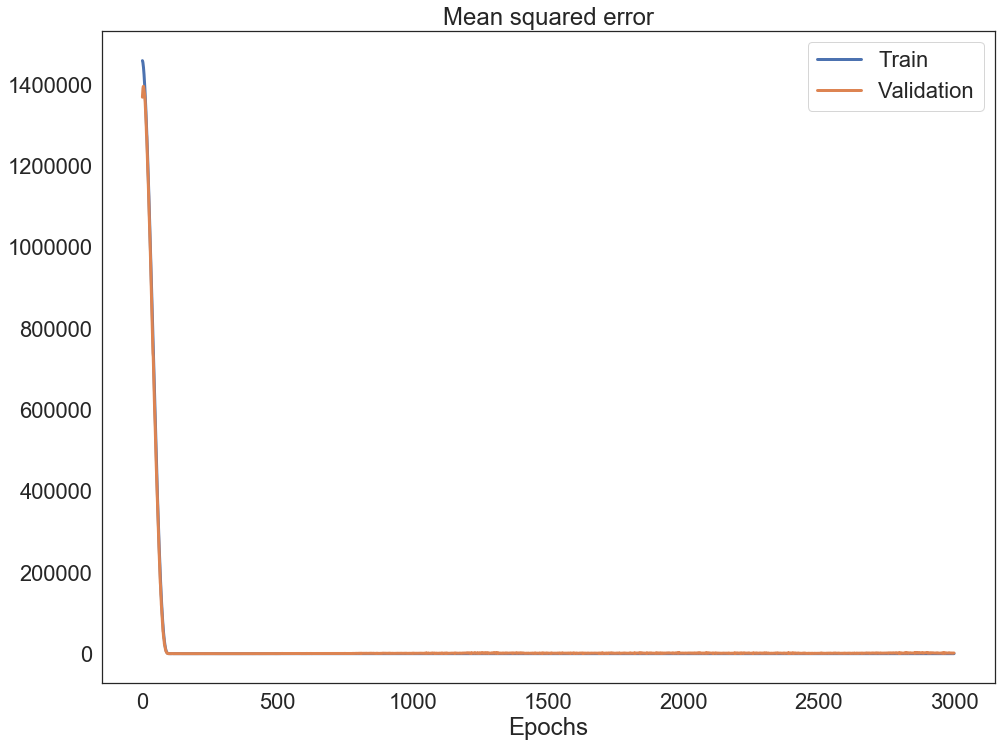

Training MSE = 5.124362999010695
Validation MSE = 40.49178880881283


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(font_scale=2)
sns.set_style("white")


def model_analysis(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    t = np.linspace(1, len(train_loss), len(train_loss))

    plt.figure(figsize=(16, 12))
    plt.title("Mean squared error")
    sns.lineplot(x=t, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=t, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()
    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")


model_analysis(history)

In [9]:
origin = pd.DataFrame(ae.predict(df))
origin.columns = df.columns
ae.predict(df)[0,:]

array([ 3.9839764e+01,  4.9543567e+00,  2.2750492e+00,  5.0997734e+00,
        1.3469945e+00,  1.5632452e+00,  1.4570000e+00,  1.4085627e+00,
        4.8056569e+00,  3.1242297e+00,  2.2481556e+00,  1.0232209e-01,
        2.0786123e+00,  3.4632587e-01,  9.3696228e+01, -4.0744919e+01,
        4.0700579e+00,  5.1967871e+03], dtype=float32)

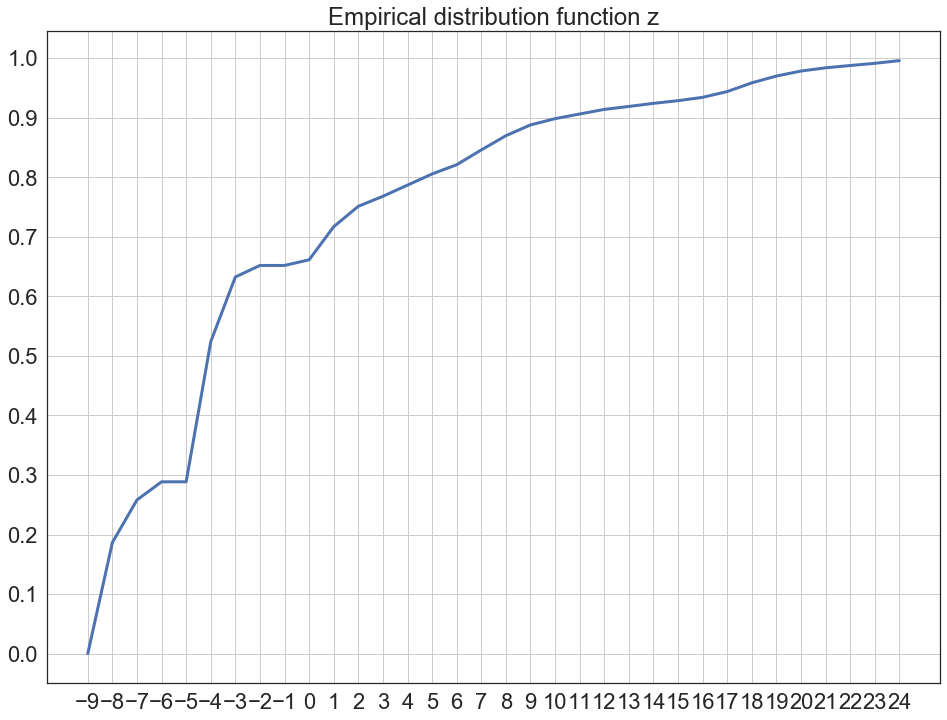

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF


ecdf = ECDF(encoder.predict(df)[:, 0])
plt.figure(figsize=(16, 12))
plt.title("Empirical distribution function z")
x = (-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

In [14]:
from scipy.interpolate import interp1d


x = (-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24)
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

In [15]:
from numpy.random import uniform
from numpy.random import seed
N = 10000


output = pd.DataFrame(decoder(inverted_edf(uniform(0.02, 0.95, N))).numpy())
output.columns = df.columns

print(output)

            age       job   marital  education   default   housing      loan  \
0     74.528244  5.687618  1.808112   4.127095  1.287249  1.514506  1.454348   
1     39.950947  5.082626  2.386036   5.253614  1.078911  1.651855  1.472839   
2     66.638954  5.745752  1.904565   4.450317  1.175446  1.577225  1.467149   
3     36.387409  5.243314  2.528690   5.690529  1.012710  1.621700  1.467934   
4     38.790298  4.978751  2.270905   5.092828  1.461493  1.564559  1.451204   
...         ...       ...       ...        ...       ...       ...       ...   
9995  63.526947  5.768684  1.942611   4.577812  1.131346  1.601965  1.472199   
9996  40.771114  5.045643  2.353204   5.153058  1.094148  1.658796  1.473971   
9997  57.727924  5.811416  2.013509   4.815395  1.049165  1.648066  1.481608   
9998  38.935043  4.969695  2.268559   5.092815  1.452147  1.560027  1.451513   
9999  39.986065  4.963532  2.281735   5.102506  1.318278  1.572268  1.458850   

       contact     month  day_of_week  

In [16]:
output.to_csv("C:/Users/mmrha/Desktop/cmu/Independent study/python/bankingauto3000_10000.csv")